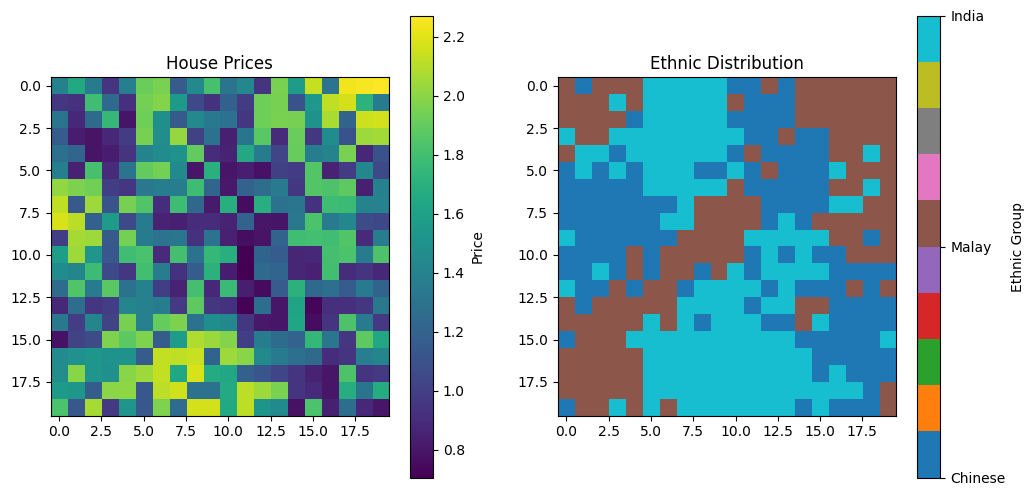

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
grid_size = 20  # Size of the lattice (20x20 grid)
num_steps = 100  # Number of simulation steps
lambda_weight = 0.5  # Weight for neighboring house prices
gamma_weight = 0.3  # Weight for ethnic similarity
alpha = 0.5  # Weight for income-house price match
beta = 0.5  # Weight for ethnic similarity in utility
ethnic_groups = ["Chinese", "Malay", "India"]  # Possible ethnicities
income_levels = {"P": 0.1, "M": 0.5, "R": 1.0}  # Income levels (Poor, Middle, Rich)

# Initialize the grid
np.random.seed(42)  # For reproducibility
house_prices = np.random.rand(grid_size, grid_size)
income_grid = np.random.choice(list(income_levels.values()), (grid_size, grid_size))
ethnicity_grid = np.random.choice(ethnic_groups, (grid_size, grid_size))

# Utility function
def calculate_utility(x, y, house_prices, income_grid, ethnicity_grid, neighborhood_radius=2):
    neighborhood = get_neighborhood(x, y, house_prices, neighborhood_radius)
    income_match = 1 - abs(income_grid[x, y] - house_prices[x, y])
    ethnic_similarity = np.sum(ethnicity_grid[neighborhood] == ethnicity_grid[x, y]) / len(neighborhood)
    return alpha * income_match + beta * ethnic_similarity

# Get the neighborhood of a cell
def get_neighborhood(x, y, grid, radius=2):
    xmin, xmax = max(0, x - radius), min(grid_size, x + radius + 1)
    ymin, ymax = max(0, y - radius), min(grid_size, y + radius + 1)
    return np.ix_(range(xmin, xmax), range(ymin, ymax))

# Update house prices
def update_house_prices(house_prices, income_grid, ethnicity_grid, radius=2):
    new_prices = np.copy(house_prices)
    for x in range(grid_size):
        for y in range(grid_size):
            neighborhood = get_neighborhood(x, y, house_prices, radius)
            neighbor_prices = house_prices[neighborhood]
            ethnic_similarity = np.sum(ethnicity_grid[neighborhood] == ethnicity_grid[x, y]) / neighbor_prices.size
            new_prices[x, y] = income_grid[x, y] + lambda_weight * np.mean(neighbor_prices) + gamma_weight * ethnic_similarity
    return new_prices

# Agent movement
def propose_move(house_prices, income_grid, ethnicity_grid):
    x1, y1 = np.random.randint(0, grid_size, size=2)
    x2, y2 = np.random.randint(0, grid_size, size=2)
    utility_before = calculate_utility(x1, y1, house_prices, income_grid, ethnicity_grid) + \
                     calculate_utility(x2, y2, house_prices, income_grid, ethnicity_grid)
    # Swap incomes and ethnicities
    income_grid[x1, y1], income_grid[x2, y2] = income_grid[x2, y2], income_grid[x1, y1]
    ethnicity_grid[x1, y1], ethnicity_grid[x2, y2] = ethnicity_grid[x2, y2], ethnicity_grid[x1, y1]
    utility_after = calculate_utility(x1, y1, house_prices, income_grid, ethnicity_grid) + \
                    calculate_utility(x2, y2, house_prices, income_grid, ethnicity_grid)
    # Reverse swap if utility decreases
    if utility_after < utility_before:
        income_grid[x1, y1], income_grid[x2, y2] = income_grid[x2, y2], income_grid[x1, y1]
        ethnicity_grid[x1, y1], ethnicity_grid[x2, y2] = ethnicity_grid[x2, y2], ethnicity_grid[x1, y1]

# Simulation
for step in range(num_steps):
    house_prices = update_house_prices(house_prices, income_grid, ethnicity_grid)
    for _ in range(grid_size):  # Attempt multiple swaps per step
        propose_move(house_prices, income_grid, ethnicity_grid)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("House Prices")
plt.imshow(house_prices, cmap="viridis", origin="upper")
plt.colorbar(label="Price")
plt.subplot(1, 2, 2)
plt.title("Ethnic Distribution")
plt.imshow(np.vectorize(ethnic_groups.index)(ethnicity_grid), cmap="tab10", origin="upper")
plt.colorbar(ticks=range(len(ethnic_groups)), label="Ethnic Group", format=lambda x, _: ethnic_groups[int(x)])
plt.show()
